# Loan Approval SVM Model

In [1]:
%reset -f

In [46]:
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import numpy             as np
import csv

from sklearn.preprocessing                  import StandardScaler
from sklearn.metrics                        import mean_squared_error, mean_absolute_error,roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, average_precision_score, f1_score
from sklearn.model_selection                import GridSearchCV, train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.svm                            import SVC

In [3]:
df = pd.read_csv("Loan-Approval-Prediction.csv")

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
# Impute missing values with column means for numerical columns
df = df.fillna(df.mean())

In [7]:
# Impute missing values with mode for categorical columns
df = df.apply(lambda col: col.fillna(col.mode()[0]) if col.dtype == 'O' else col)

In [8]:
## drop na's
df = df.dropna()

In [9]:
# use to get variables from column
df['Education'].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [10]:
# Map variables
df['Loan_Status_ind'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Male'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married_ind'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Education_ind'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed_ind'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})

In [11]:
# get dummies
dummy_df = pd.get_dummies(df['Dependents'], prefix='Dependents')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_df], axis=1)

In [12]:
# get dummies
dummy_df = pd.get_dummies(df['Property_Area'], prefix='Property_Area')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_df], axis=1)

In [13]:
df = df[['Loan_Status_ind', 'Male', 'Married_ind','Education_ind','Self_Employed_ind','ApplicantIncome', 
         'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History','Dependents_0', 'Dependents_1', 
         'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']]

In [14]:
df.head()

,Loan_Status_ind,Male,Married_ind,Education_ind,Self_Employed_ind,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0,1,0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,0,0,1
1,0,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0,1,0,0
2,1,1,1,1,1,3000,0.0,66.000000,360.0,1.0,1,0,0,0,0,0,1
3,1,1,1,0,0,2583,2358.0,120.000000,360.0,1.0,1,0,0,0,0,0,1
4,1,1,0,1,0,6000,0.0,141.000000,360.0,1.0,1,0,0,0,0,0,1


In [15]:
#df.describe()

In [16]:
#df.columns

In [17]:
# Check for any NaN or infinite values across rows
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].count().sum()

0

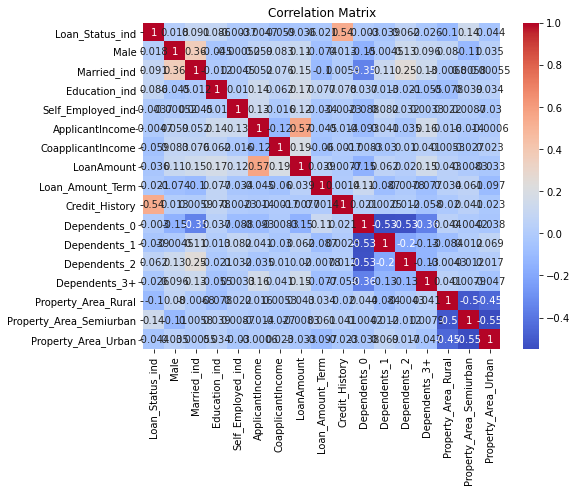

In [18]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, 
            cmap="coolwarm"
           )
#plt.xlabel("Predicted Labels")
#plt.ylabel("True Labels")
plt.title("Correlation Matrix")
plt.show()

In [19]:
X = df[['Male', 'Married_ind','Education_ind','Self_Employed_ind','ApplicantIncome', 
         'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History','Dependents_0', 'Dependents_1', 
         'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']]

In [20]:
y = df['Loan_Status_ind']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler()

In [23]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [25]:
# Create an SVM classifier
#svm = SVC()
svm = SVC(kernel='sigmoid', gamma='auto', C=0.05, max_iter=30000, probability=True)

In [26]:
#feature_selector = SelectFromModel(estimator=svm, threshold='median')

NameError: name 'SelectFromModel' is not defined

In [ ]:
# Create a RandomizedSearchCV object
#random_search = RandomizedSearchCV(estimator=svm, 
 #                                  param_distributions=param_grid, n_iter=20, 
  #                                 cv=5, random_state=42)

In [ ]:
# Fit the RandomizedSearchCV object on the training data
#random_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters and best estimator from RandomizedSearchCV
#best_params = random_search.best_params_
#best_estimator = random_search.best_estimator_

In [27]:
gs_svm = GridSearchCV(svm, param_grid, cv=3, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

In [28]:
# Fit the GridSearchCV object on the training data
gs_svm.fit(X_train, y_train)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


GridSearchCV(cv=3,
             estimator=SVC(C=0.05, gamma='auto', kernel='sigmoid',
                           max_iter=30000, probability=True),
             n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
# Get the best parameters and best estimator from GridSearchCV
best_params = gs_svm.best_params_
best_estimator = gs_svm.best_estimator_

In [30]:
# Evaluate the model on the test data
accuracy = best_estimator.score(X_test, y_test)
accuracy2 = best_estimator.score(X_train,y_train)
print("Best Parameters:", best_params)
print("Accuracy on Test Data:", accuracy)
print("Accuracy on Training Data", accuracy2)

Best Parameters: {'C': 0.5, 'gamma': 'scale', 'kernel': 'sigmoid'}
Accuracy on Test Data: 0.7804878048780488
Accuracy on Training Data 0.7983706720977597


In [31]:
# tuned svm based on grid search
tuned_svm = SVC(kernel='sigmoid', gamma='auto', C=0.3, max_iter=30000)

In [32]:
# Predict the labels on the test data
y_pred = gs_svm.predict(X_test)

In [33]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

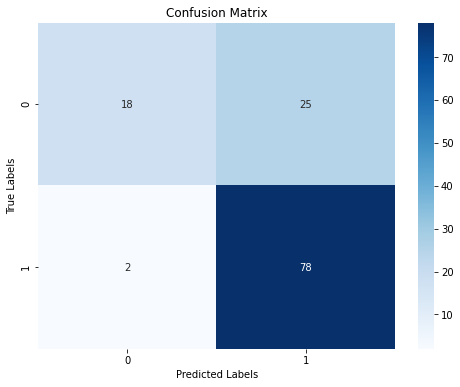

In [34]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", 
           # xticklabels=df.target_names, yticklabels=df.target_names
           )
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [35]:
# Get predicted probabilities for the positive class (class 1)
y_prob = gs_svm.predict_proba(X_test)[:, 1]

In [36]:
# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

In [37]:
roc_auc

0.6718023255813954

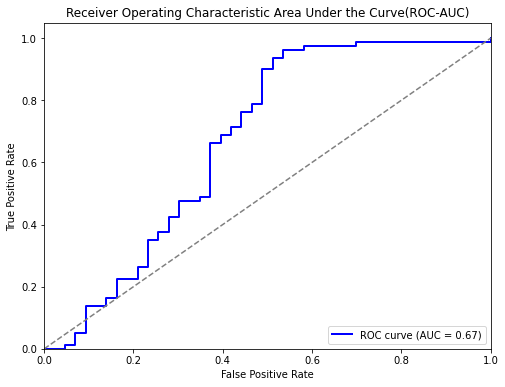

In [38]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Area Under the Curve(ROC-AUC)')
plt.legend(loc='lower right')
plt.show()

In [42]:
# Compute the Precision-Recall curve and PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

In [43]:
# Calculate the Precision-Recall score
pr_score = average_precision_score(y_test, y_prob)

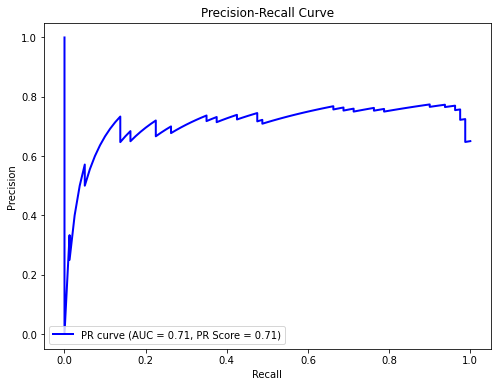

In [44]:
# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AUC = %0.2f, PR Score = %0.2f)' % (pr_auc, pr_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [45]:
# Print the PR AUC and PR score
print("PR AUC:", pr_auc)
print("Precision-Recall Score:", pr_score)

PR AUC: 0.7067359913625334
Precision-Recall Score: 0.7147875959797161


In [47]:
threshold = 0.5  # You can adjust the threshold if needed
y_pred = (y_prob >= threshold).astype(int)
f1 = f1_score(y_test, y_pred)

In [48]:
print("F1 Score:", f1)

F1 Score: 0.8524590163934427
